In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-08-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-02-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-02-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-04-01-02-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-02-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-03-01-01-01-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-02-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-05-01-01-02-02.wav
/kaggle/input/ravdess-emotional-speech-audio/Actor_0

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
Ravdess = '/kaggle/input/ravdess-emotional-speech-audio'

In [4]:
import re

Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12) - Female (as the actor ID number is even)

In [5]:
records = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        records.append([filename, os.path.join(dirname,filename)])

data = pd.DataFrame(records, columns=['filename','path'])
data['actor'] = data['path'].apply(lambda x: re.findall("\w+_\d+",x)[0])
data = data[data['actor']!="audio_speech_actors_01"]
data.reset_index(inplace=True,drop=True)
data['type'] = data['filename'].apply(lambda x: re.split("-\d+\.wav",x)[0])
data

filename  \
0     03-01-08-01-01-01-02.wav   
1     03-01-01-01-01-01-02.wav   
2     03-01-07-02-01-02-02.wav   
3     03-01-07-01-01-02-02.wav   
4     03-01-01-01-02-01-02.wav   
...                        ...   
1435  03-01-06-01-01-02-07.wav   
1436  03-01-05-01-02-02-07.wav   
1437  03-01-04-02-01-01-07.wav   
1438  03-01-07-02-02-02-07.wav   
1439  03-01-05-02-01-02-07.wav   

                                                   path     actor  \
0     /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
1     /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
2     /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
3     /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
4     /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
...                                                 ...       ...   
1435  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
1436  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
1437  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
1438  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
1439  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   

                   type  
0     03-01-08-01-01-01  
1     03-01-01-01-01-01  
2     03-01-07-02-01-02  
3     03-01-07-01-01-02  
4     03-01-01-01-02-01  
...                 ...  
1435  03-01-06-01-01-02  
1436  03-01-05-01-02-02  
1437  03-01-04-02-01-01  
1438  03-01-07-02-02-02  
1439  03-01-05-02-01-02  

[1440 rows x 4 columns]

In [6]:
data['actor'].nunique()

24

In [7]:
data['actor'].value_counts()

Actor_02    60
Actor_17    60
Actor_18    60
Actor_13    60
Actor_03    60
Actor_14    60
Actor_09    60
Actor_10    60
Actor_19    60
Actor_04    60
Actor_22    60
Actor_24    60
Actor_23    60
Actor_12    60
Actor_06    60
Actor_15    60
Actor_08    60
Actor_20    60
Actor_11    60
Actor_01    60
Actor_21    60
Actor_16    60
Actor_05    60
Actor_07    60
Name: actor, dtype: int64

In [8]:
filter_list = []
for a in ["03","04"]:
    for b in ["01","02"]:
        for c in ["01","02"]:
            for d in ["01","02"]:
                filter_list.append(f"03-01-{a}-{b}-{c}-{d}")

data = data[data['type'].isin(filter_list)]
data.reset_index(inplace=True,drop=True)
data['class'] = data['type'].apply(lambda x: 'happy' if x.startswith('03-01-03') else 'sad')
data['gender'] = data['actor'].apply(lambda x: 'female' if int(x.split('_')[1])%2==0 else 'male')

In [9]:
data

filename  \
0    03-01-04-01-02-01-02.wav   
1    03-01-03-01-01-01-02.wav   
2    03-01-03-01-01-02-02.wav   
3    03-01-04-02-02-02-02.wav   
4    03-01-03-02-01-02-02.wav   
..                        ...   
379  03-01-04-02-02-01-07.wav   
380  03-01-04-01-01-01-07.wav   
381  03-01-03-01-01-02-07.wav   
382  03-01-03-01-02-01-07.wav   
383  03-01-04-02-01-01-07.wav   

                                                  path     actor  \
0    /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
1    /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
2    /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
3    /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
4    /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
..                                                 ...       ...   
379  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
380  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
381  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
382  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
383  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   

                  type  class  gender  
0    03-01-04-01-02-01    sad  female  
1    03-01-03-01-01-01  happy  female  
2    03-01-03-01-01-02  happy  female  
3    03-01-04-02-02-02    sad  female  
4    03-01-03-02-01-02  happy  female  
..                 ...    ...     ...  
379  03-01-04-02-02-01    sad    male  
380  03-01-04-01-01-01    sad    male  
381  03-01-03-01-01-02  happy    male  
382  03-01-03-01-02-01  happy    male  
383  03-01-04-02-01-01    sad    male  

[384 rows x 6 columns]

In [10]:
data['gender'].value_counts()

female    192
male      192
Name: gender, dtype: int64

In [11]:
data.loc[1,'filename'] in filter_list

False

In [13]:
def show_waveplot(audio_path,name,label,gender):
    x , sr = librosa.load(audio_path)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: {name}, Class: {label}, Gender: {gender}")

def show_spectrogram(audio_path,name,label,gender):
    x , sr = librosa.load(audio_path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram: {name}, Class: {label}, Gender: {gender}")

def show_zcr(audio_path,name,label,gender):
    x , sr = librosa.load(audio_path)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title(f'Zero Crossing Rate: {name}, Class: {label}, Gender: {gender}')
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,name,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Centroids: {name}, Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.show()

def show_spectral_rolloff(audio_path,name,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Rolloff: {name}, Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr, roll_percent=0.01)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.show()

def show_mfccs(audio_path,name,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC: {name}, Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

In [14]:
happy =  data[data['class']=='happy'].sample(3)
happy

filename  \
328  03-01-03-02-02-01-03.wav   
188  03-01-03-02-02-02-12.wav   
340  03-01-03-02-02-02-13.wav   

                                                  path     actor  \
328  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_03   
188  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_12   
340  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_13   

                  type  class  gender  
328  03-01-03-02-02-01  happy    male  
188  03-01-03-02-02-02  happy  female  
340  03-01-03-02-02-02  happy    male

In [15]:
sad = data[data['class']=='sad'].sample(3)
sad

filename  \
23  03-01-04-01-01-02-17.wav   
0   03-01-04-01-02-01-02.wav   
45  03-01-04-02-02-01-05.wav   

                                                 path     actor  \
23  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_17   
0   /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
45  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_05   

                 type class  gender  
23  03-01-04-01-01-02   sad    male  
0   03-01-04-01-02-01   sad  female  
45  03-01-04-02-02-01   sad    male

In [16]:
import IPython.display as ipd

## Happy

In [17]:
ipd.Audio(happy.iloc[0].path)

In [18]:
ipd.Audio(happy.iloc[1].path)

In [19]:
ipd.Audio(happy.iloc[2].path)

## Sad

In [20]:
ipd.Audio(sad.iloc[0].path)

In [21]:
ipd.Audio(sad.iloc[1].path)

In [22]:
ipd.Audio(sad.iloc[2].path)

## WavePlot

### happy

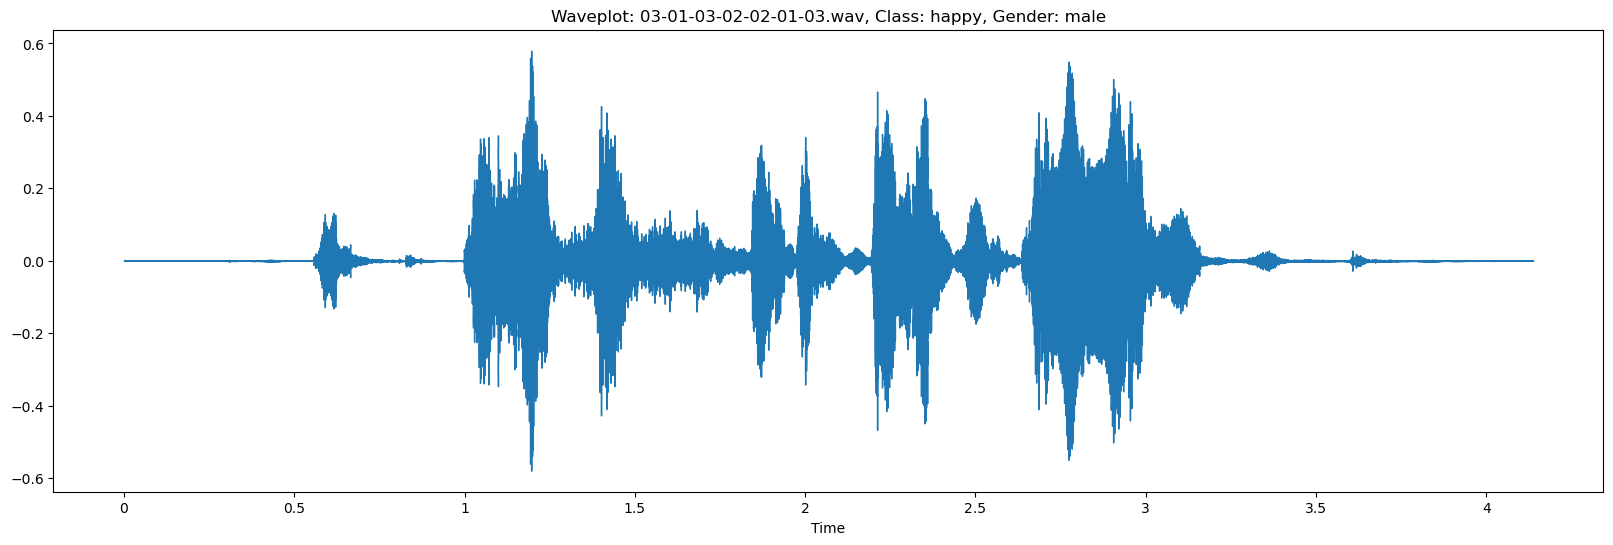

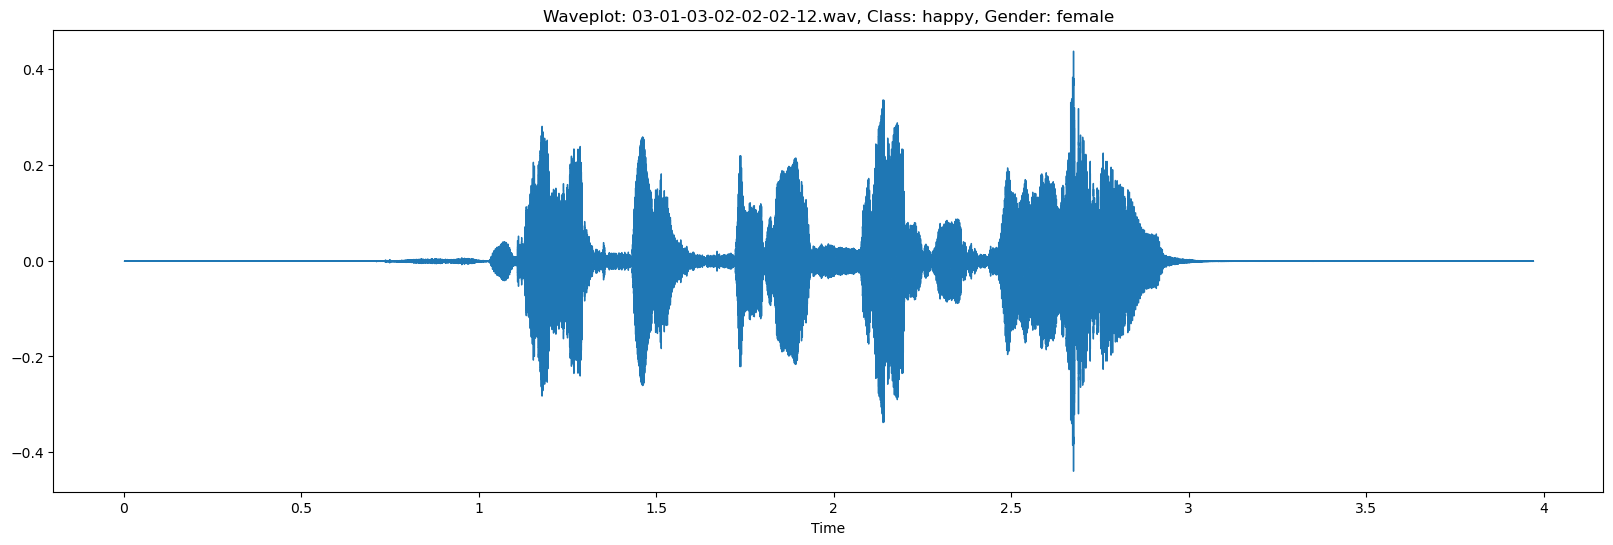

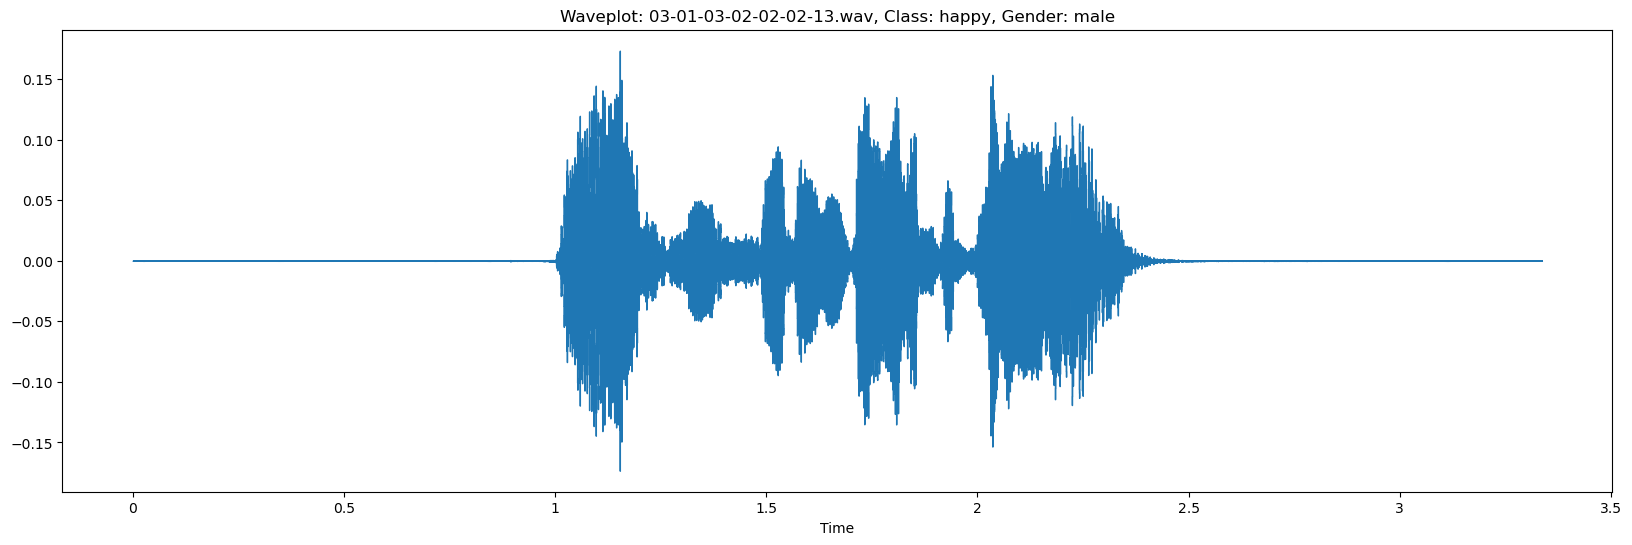

In [23]:
show_waveplot(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_waveplot(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_waveplot(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

### Sad

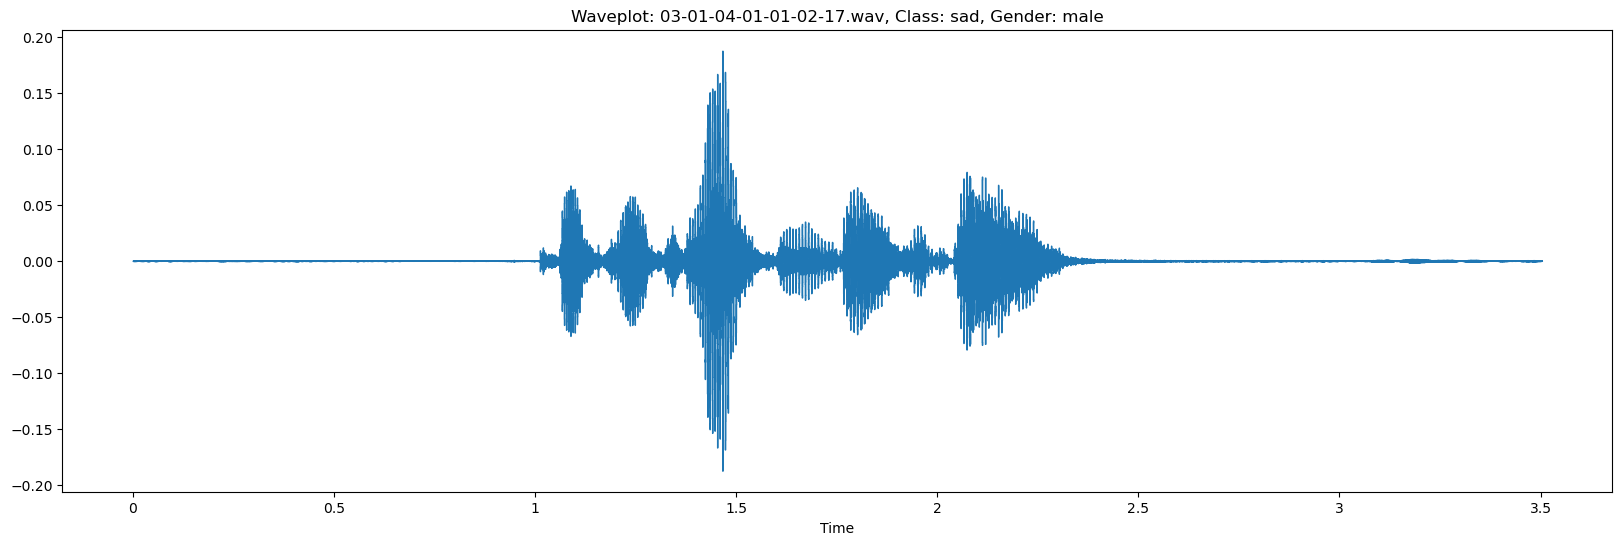

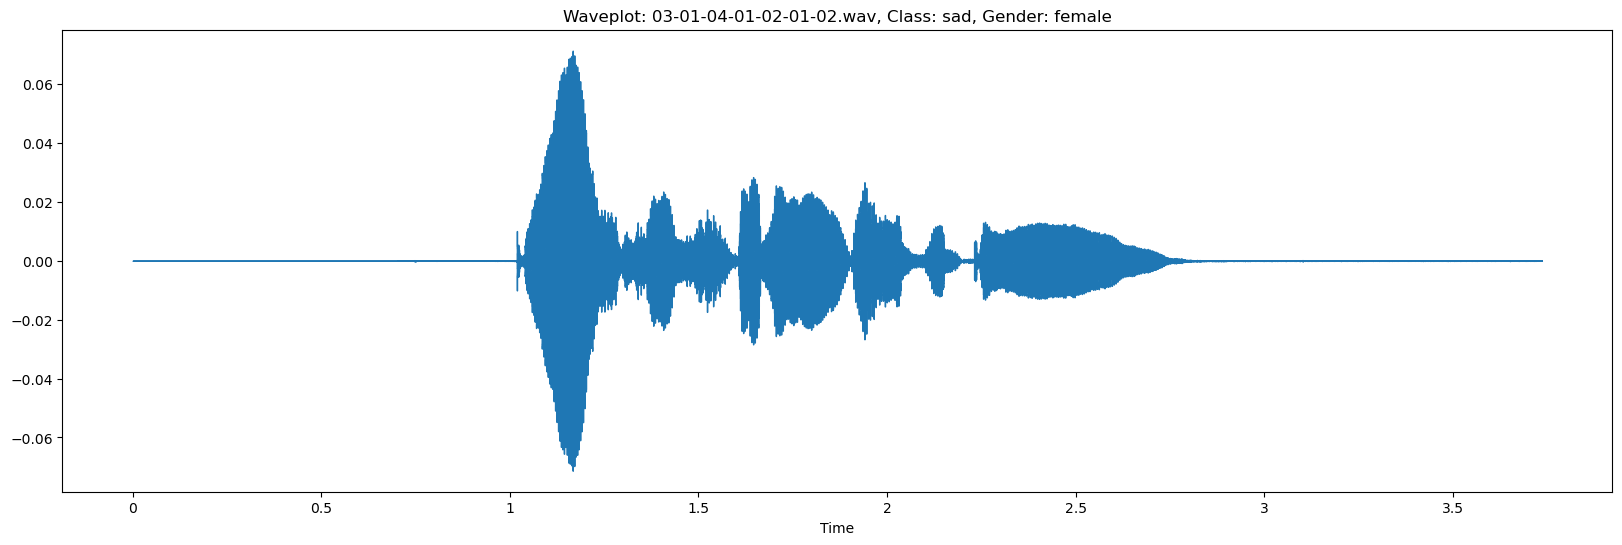

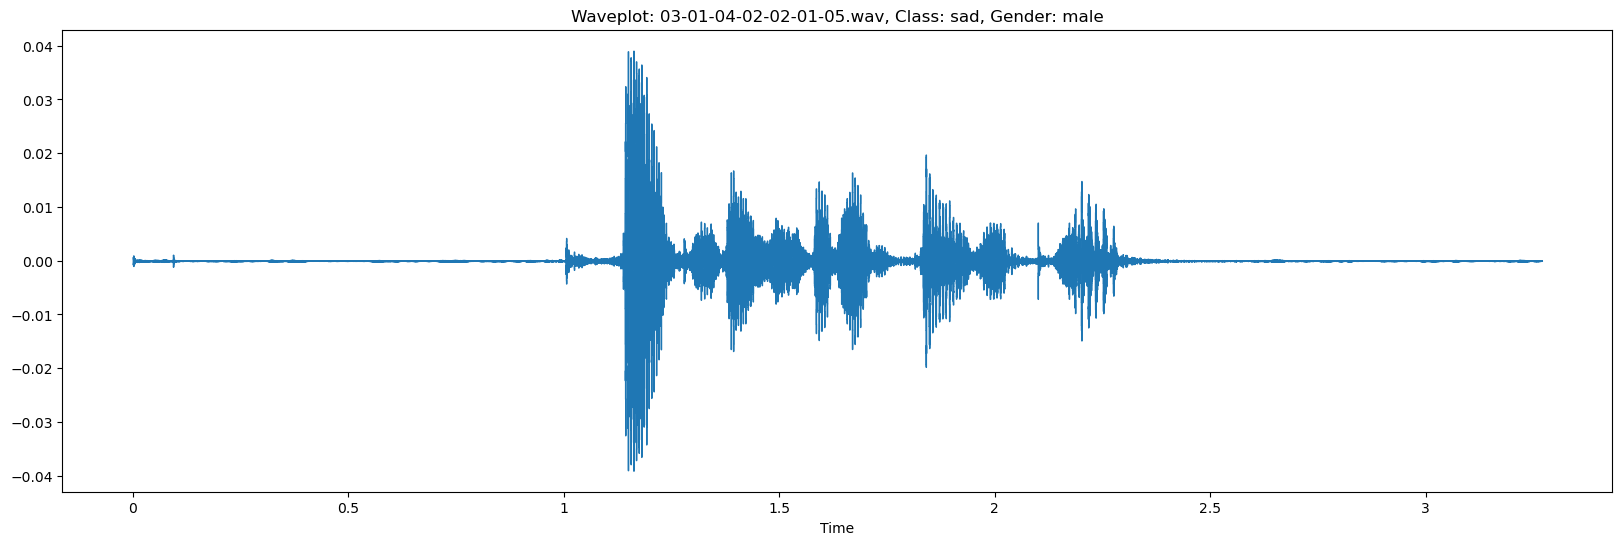

In [24]:
show_waveplot(sad.iloc[0].path,sad.iloc[0].filename,'sad',sad.iloc[0].gender)
show_waveplot(sad.iloc[1].path,sad.iloc[1].filename,'sad',sad.iloc[1].gender)
show_waveplot(sad.iloc[2].path,sad.iloc[2].filename,'sad',sad.iloc[2].gender)

## Spectrogram Happy

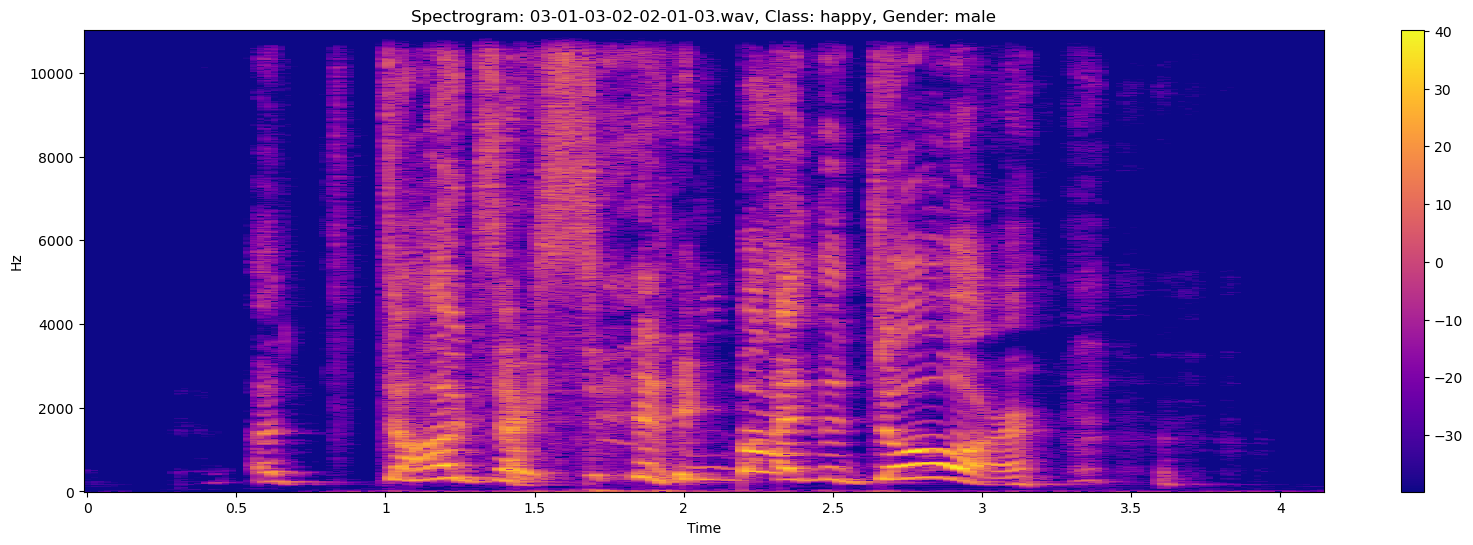

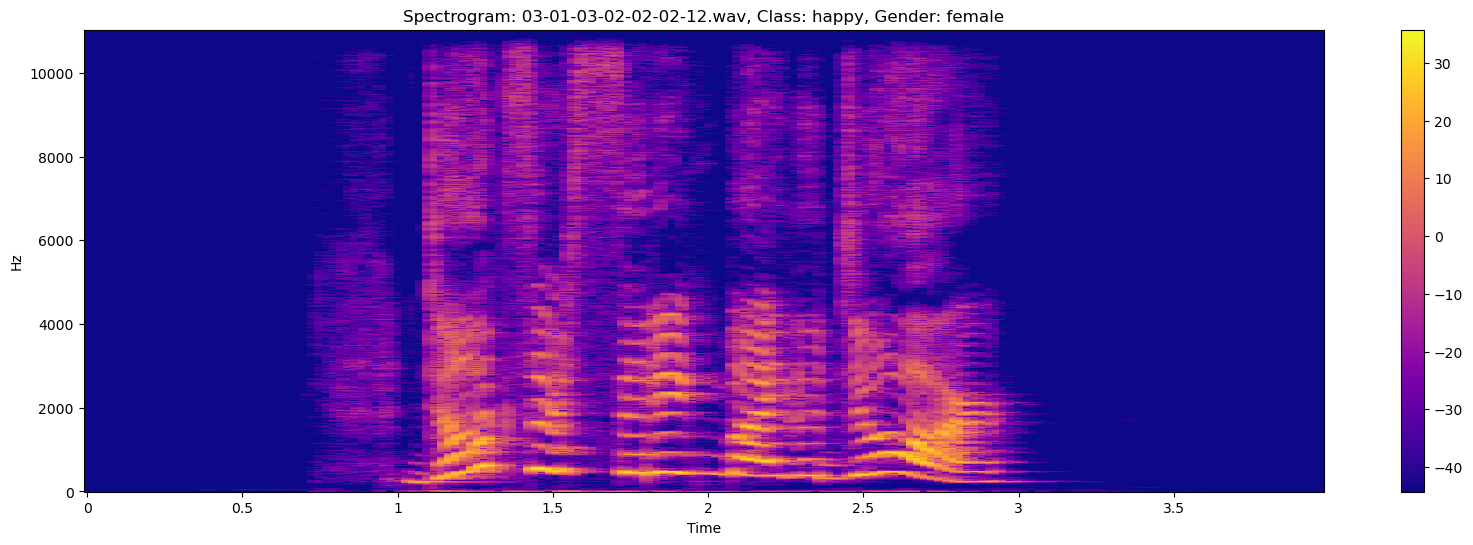

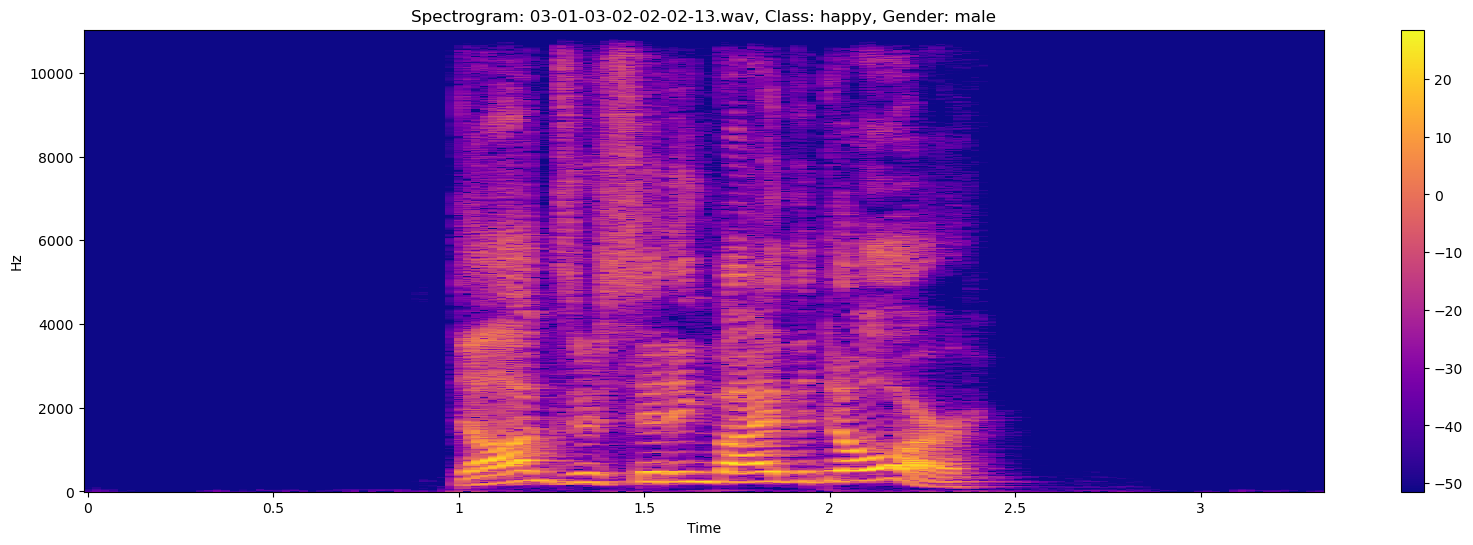

In [25]:
show_spectrogram(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_spectrogram(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_spectrogram(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

## Spectrogram - Sad

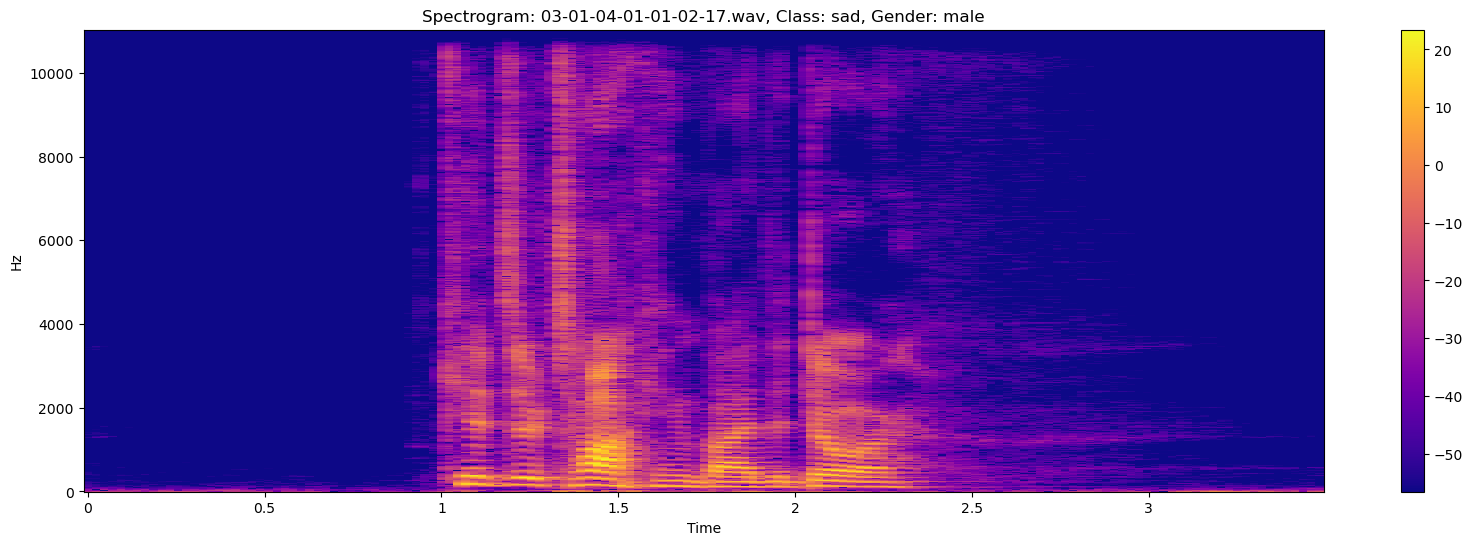

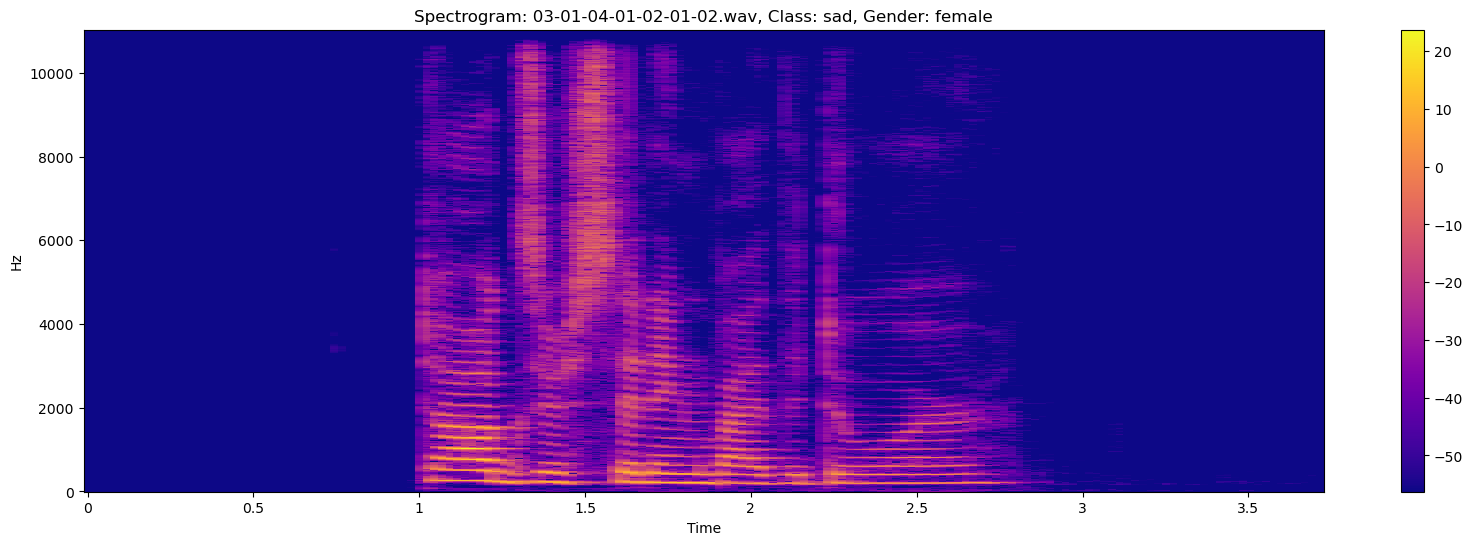

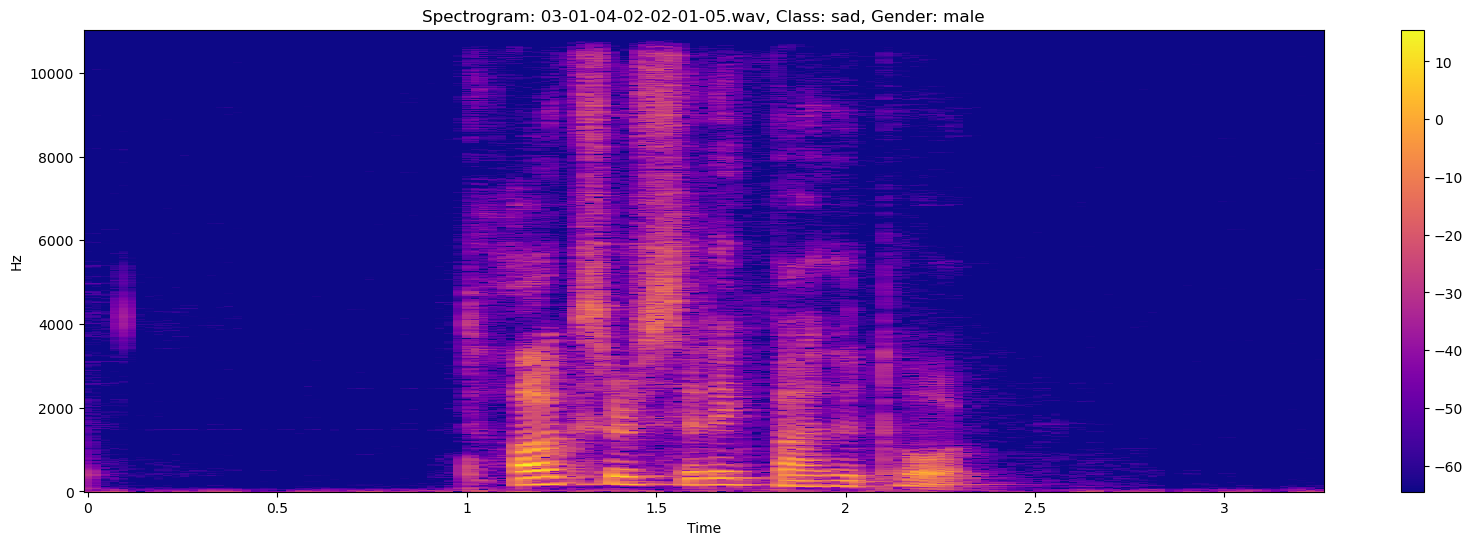

In [26]:
show_spectrogram(sad.iloc[0].path,sad.iloc[0].filename,'sad',sad.iloc[0].gender)
show_spectrogram(sad.iloc[1].path,sad.iloc[1].filename,'sad',sad.iloc[1].gender)
show_spectrogram(sad.iloc[2].path,sad.iloc[2].filename,'sad',sad.iloc[2].gender)

## ZCR - HAPPY

Sum of zero crossing  13917


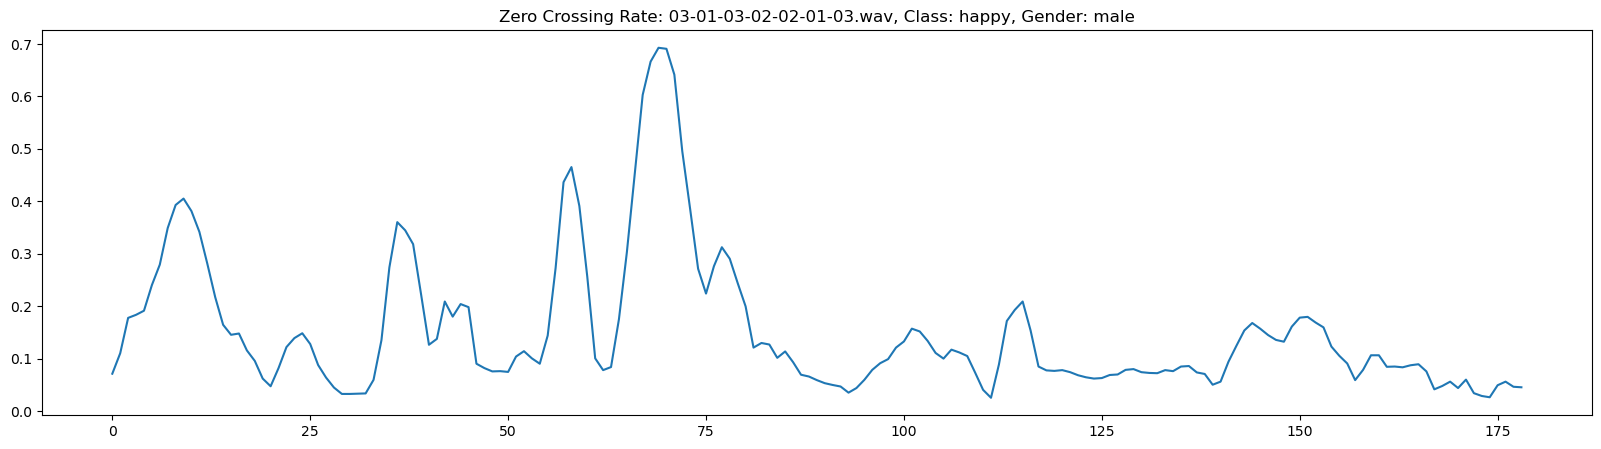

Sum of zero crossing  21531


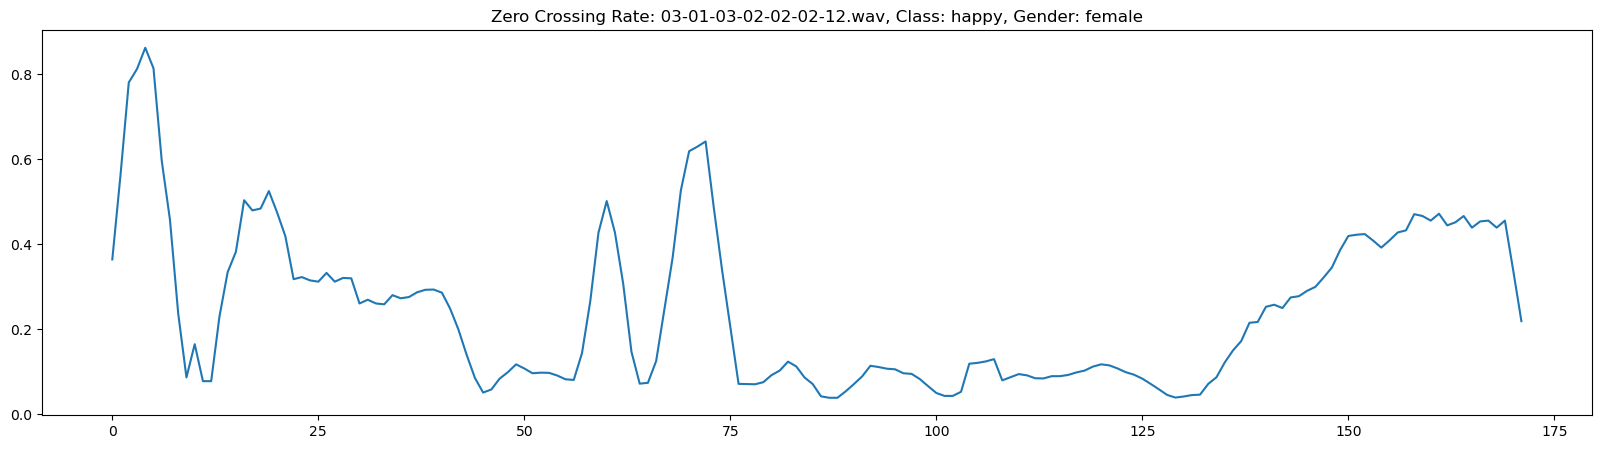

Sum of zero crossing  22119


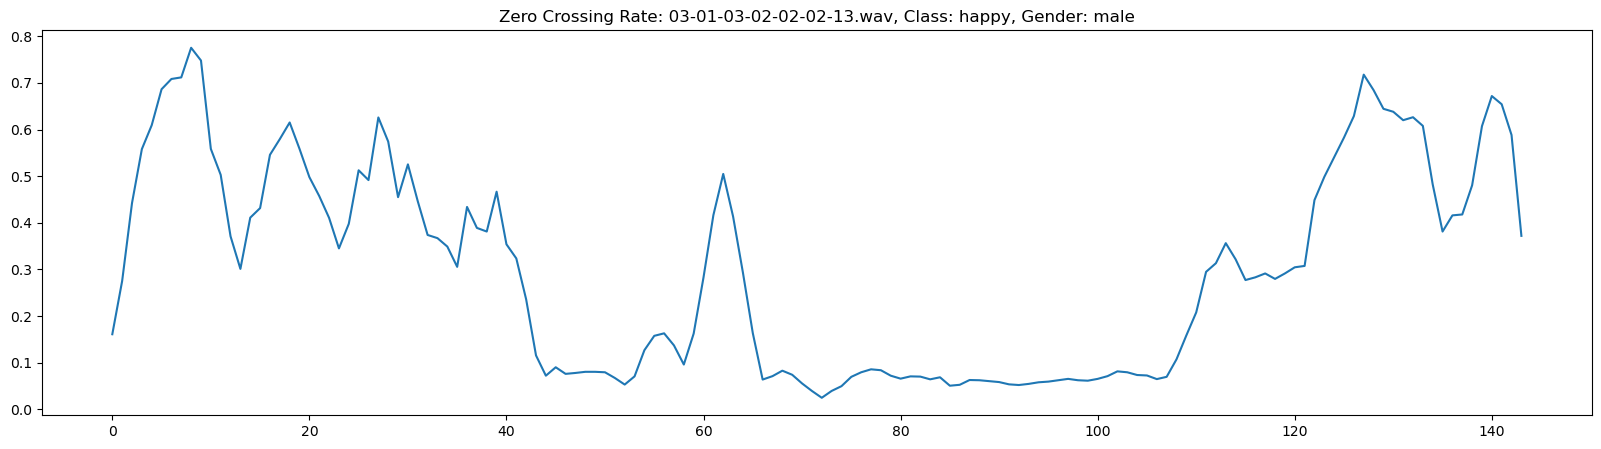

In [27]:
show_zcr(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_zcr(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_zcr(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

## ZCR - SAD

Sum of zero crossing  9364


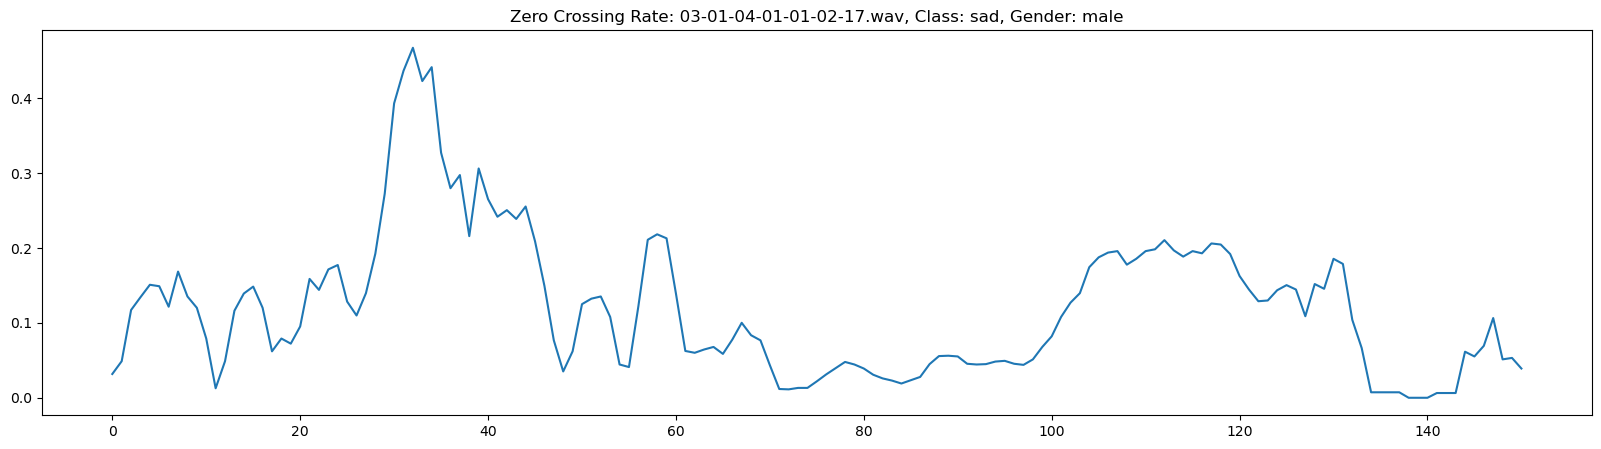

Sum of zero crossing  21433


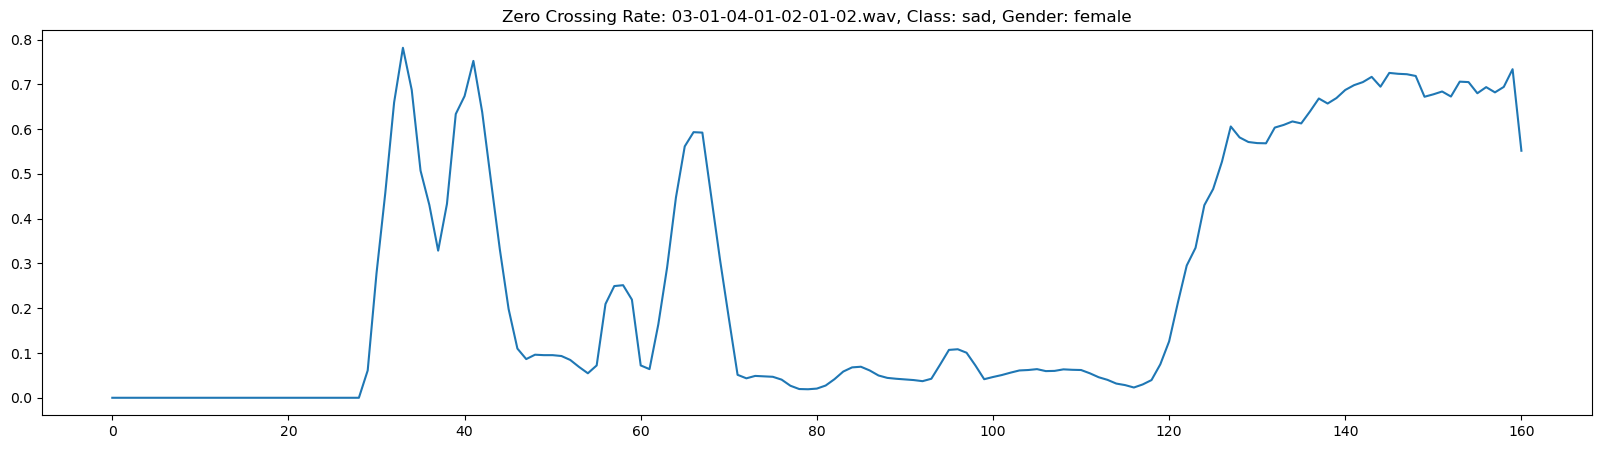

Sum of zero crossing  15765


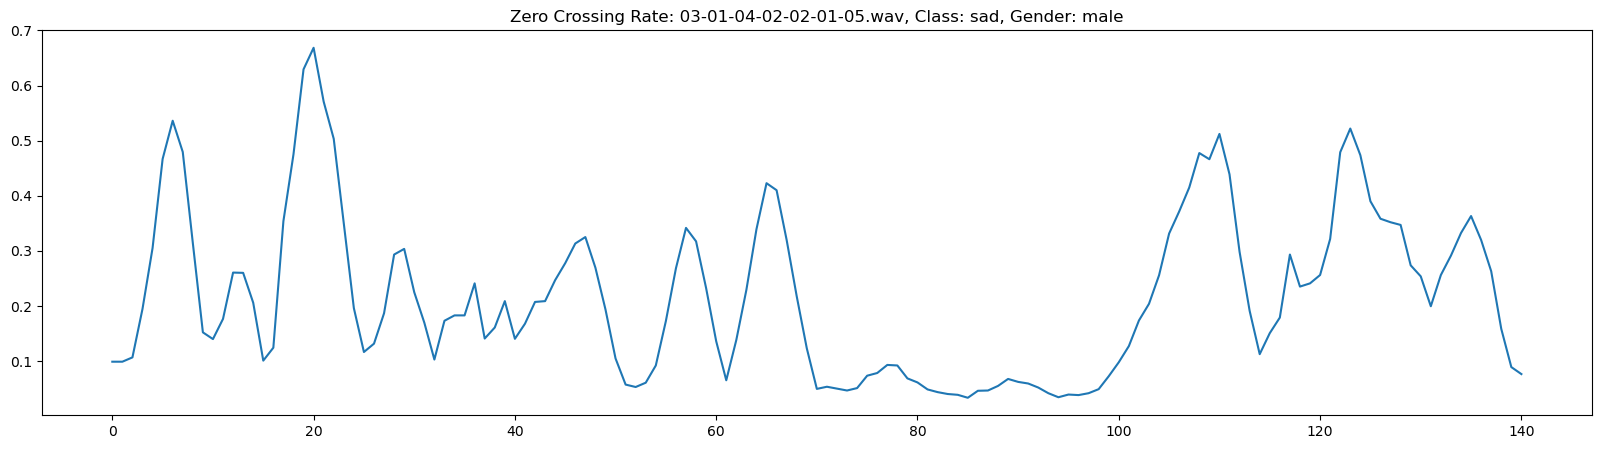

In [28]:
show_zcr(sad.iloc[0].path,sad.iloc[0].filename,'sad',sad.iloc[0].gender)
show_zcr(sad.iloc[1].path,sad.iloc[1].filename,'sad',sad.iloc[1].gender)
show_zcr(sad.iloc[2].path,sad.iloc[2].filename,'sad',sad.iloc[2].gender)

## Spectral centroid - Happy

TypeError: spectral_centroid() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given

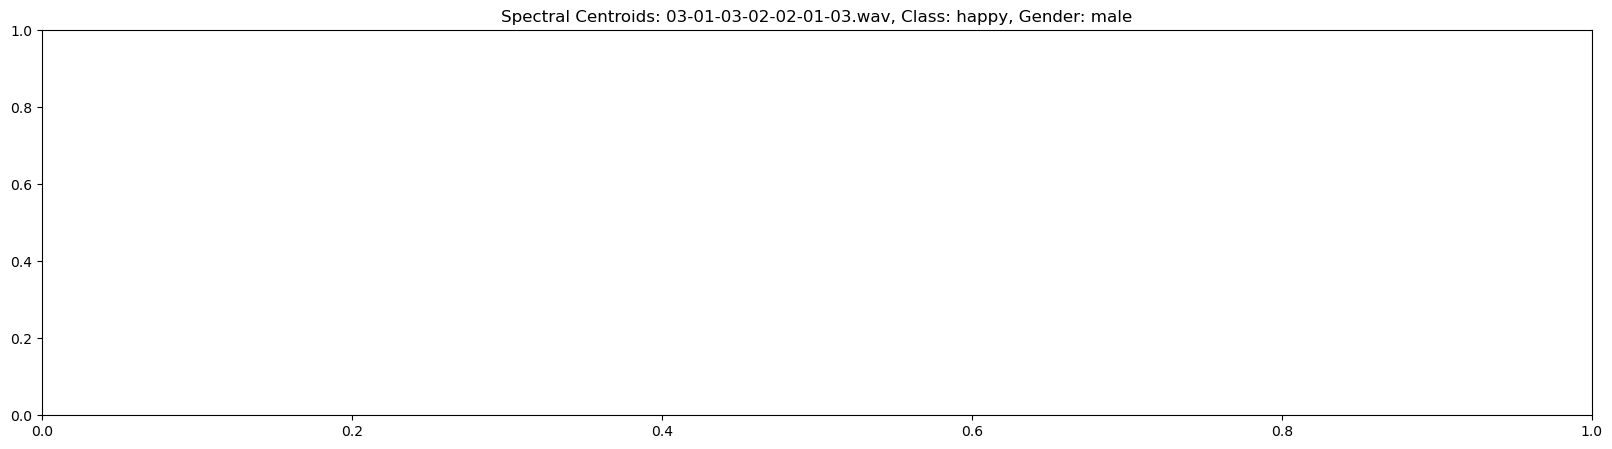

In [29]:
show_spectral_centroids(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_spectral_centroids(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_spectral_centroids(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

## Spectrak Rolloff

TypeError: spectral_rolloff() takes 0 positional arguments but 1 positional argument (and 2 keyword-only arguments) were given

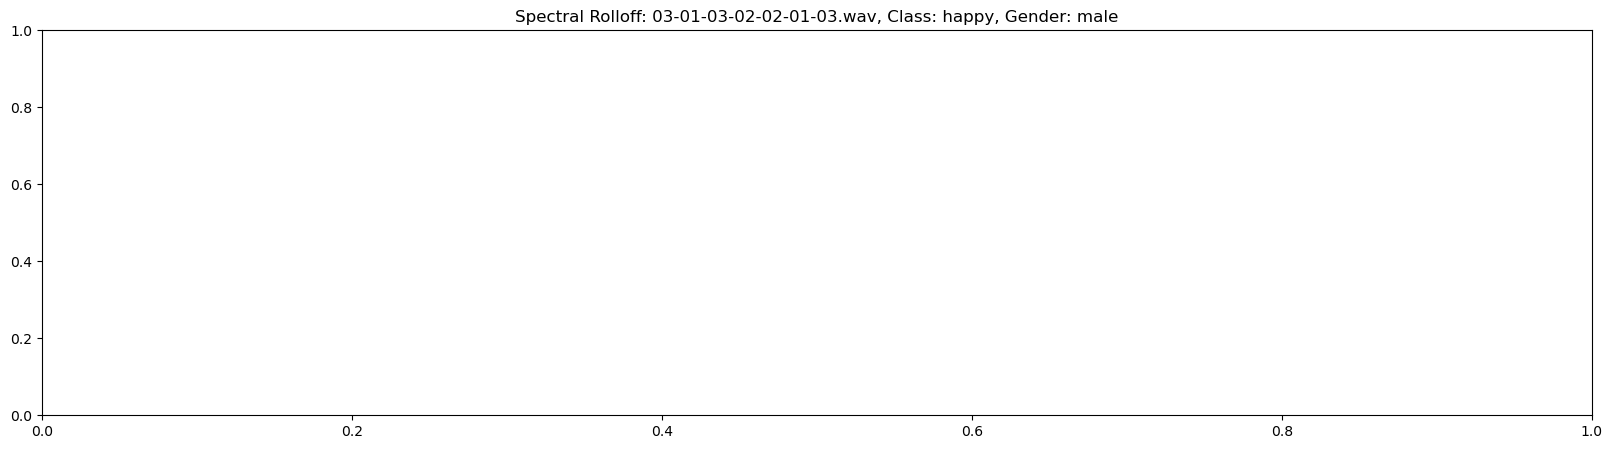

In [30]:
show_spectral_rolloff(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_spectral_rolloff(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_spectral_rolloff(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

## MFCC - HAPPY

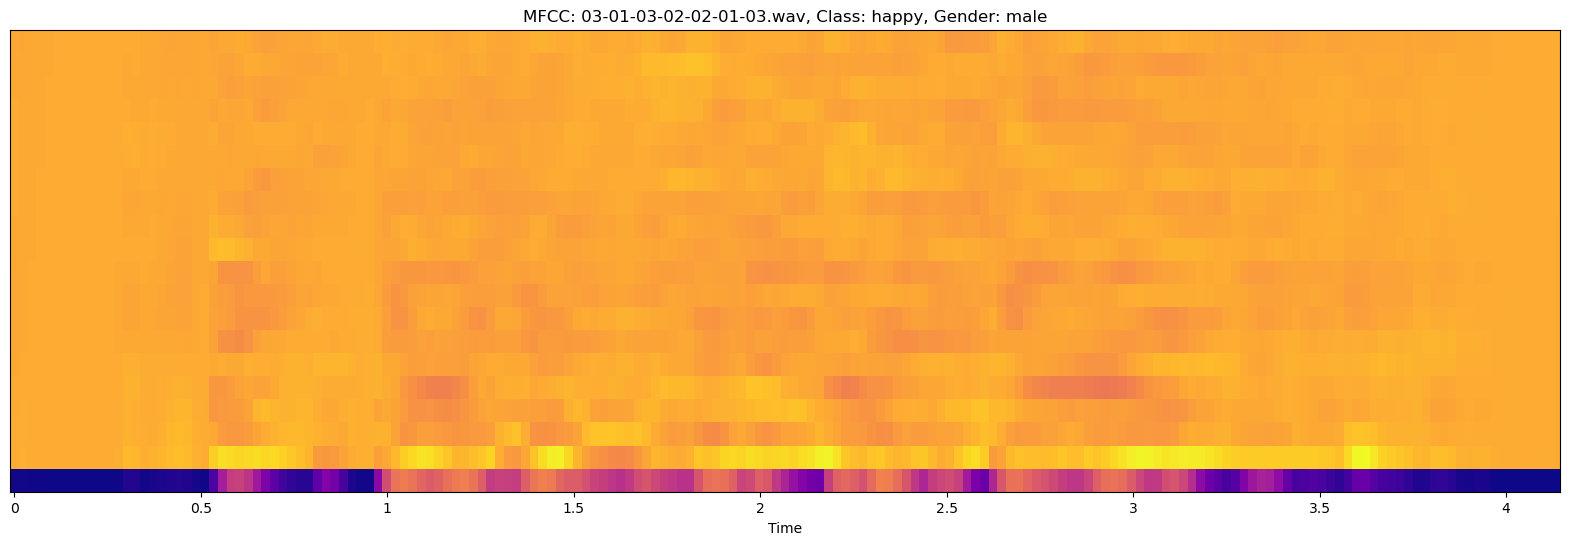

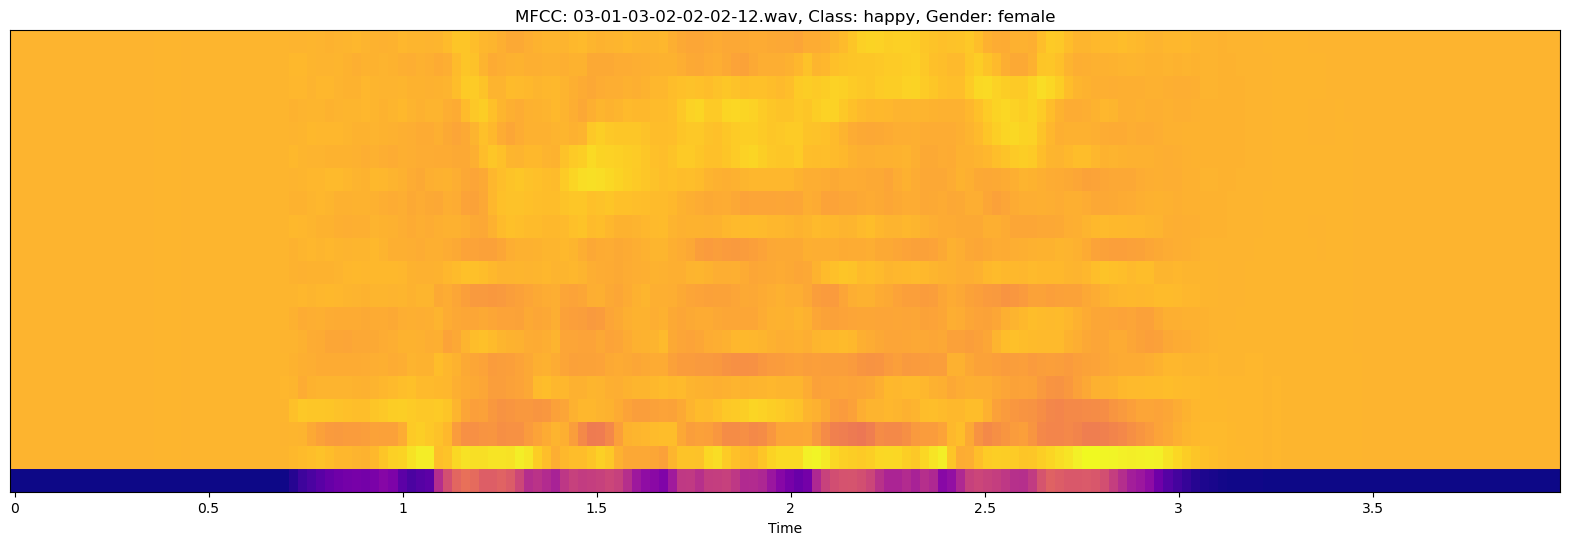

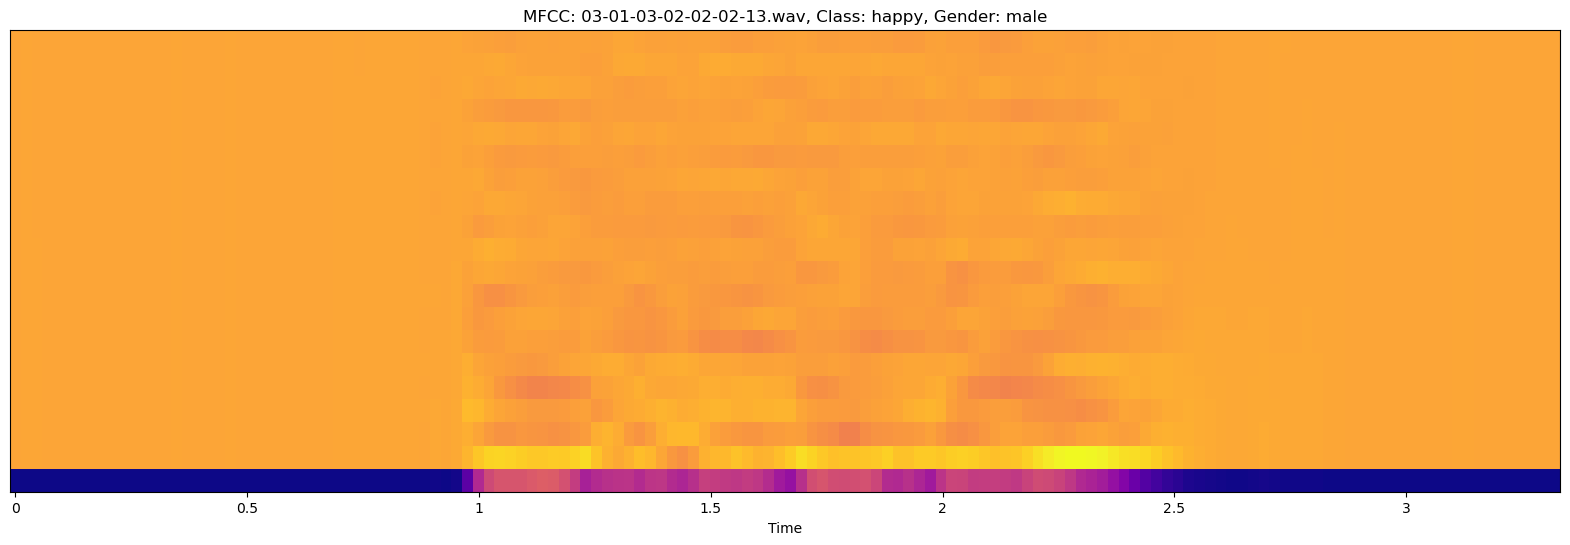

In [31]:
show_mfccs(happy.iloc[0].path,happy.iloc[0].filename,'happy',happy.iloc[0].gender)
show_mfccs(happy.iloc[1].path,happy.iloc[1].filename,'happy',happy.iloc[1].gender)
show_mfccs(happy.iloc[2].path,happy.iloc[2].filename,'happy',happy.iloc[2].gender)

## MFCC - SAD

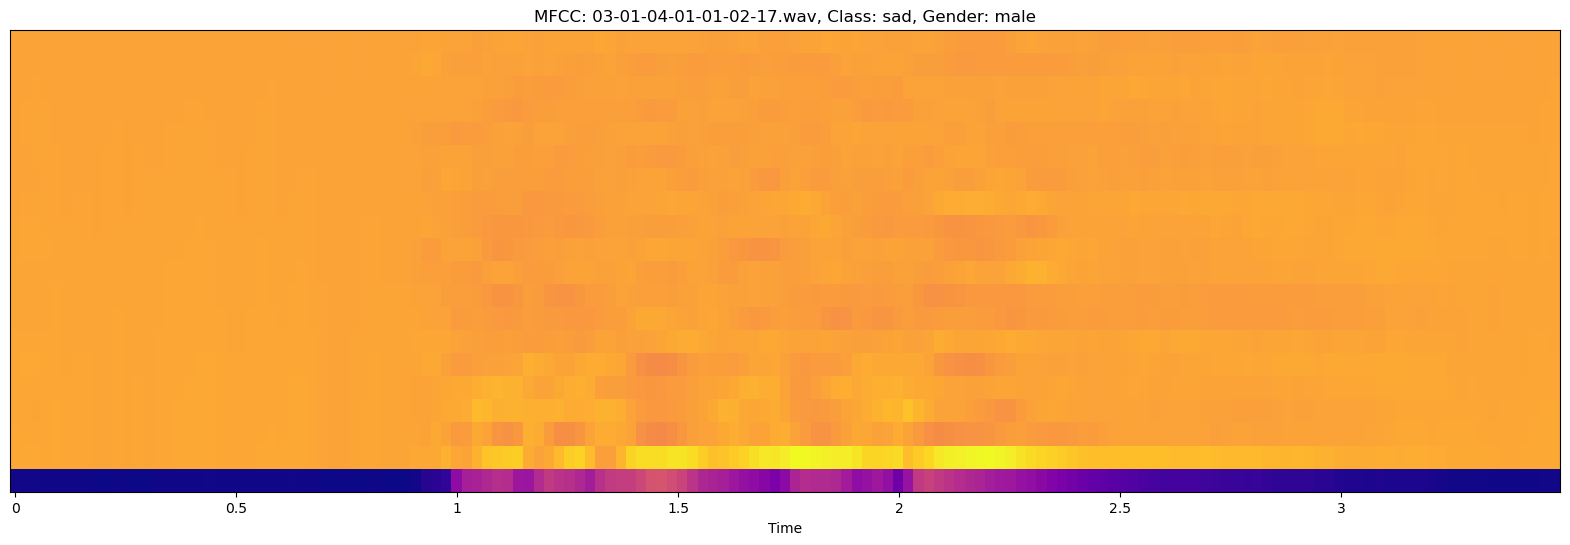

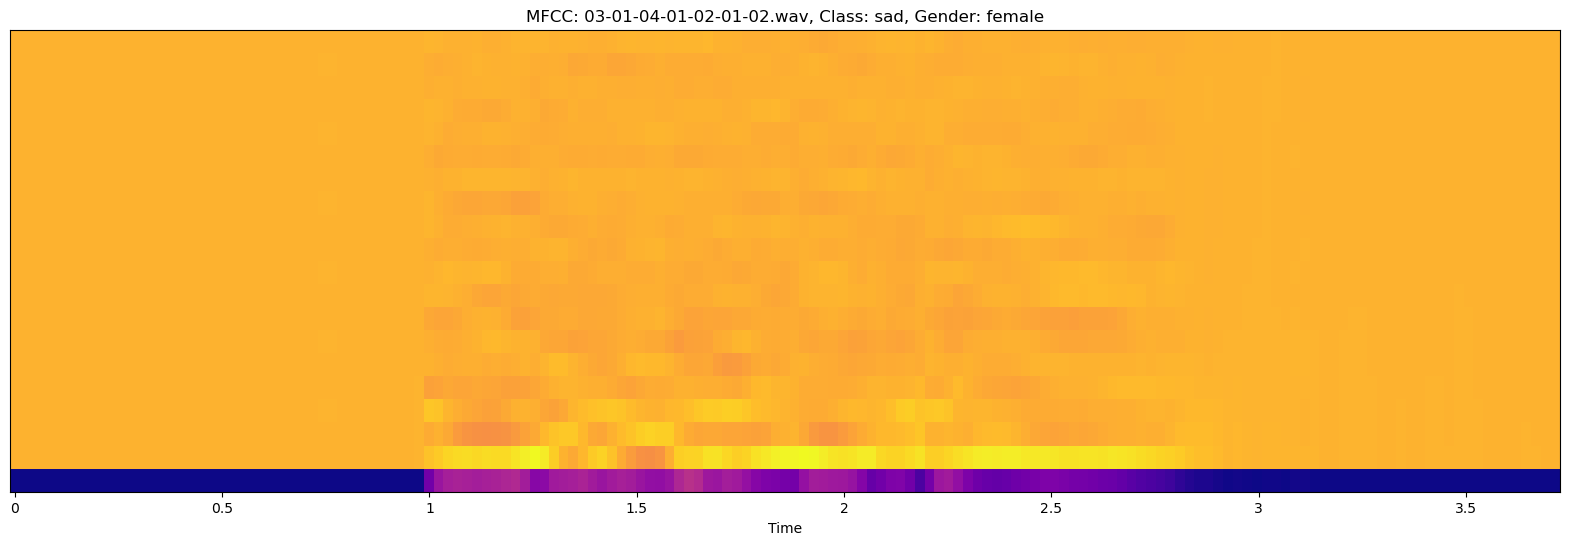

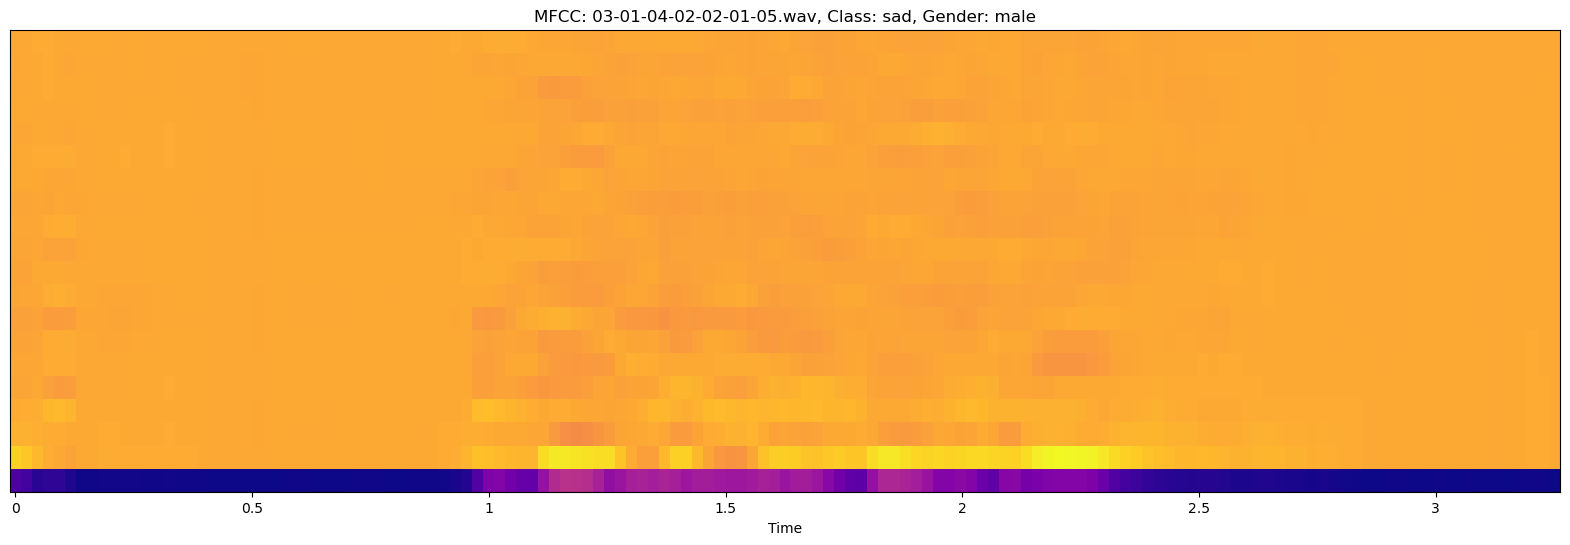

In [32]:
show_mfccs(sad.iloc[0].path,sad.iloc[0].filename,'sad',sad.iloc[0].gender)
show_mfccs(sad.iloc[1].path,sad.iloc[1].filename,'sad',sad.iloc[1].gender)
show_mfccs(sad.iloc[2].path,sad.iloc[2].filename,'sad',sad.iloc[2].gender)

# Modelling

In [34]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
def feature_extraction(df, mfcc=True):
    features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        x , sr = librosa.load(record['path'])
        mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=40),axis=1)
        mean_ms = np.mean(librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128),axis=1)
        features.append(mean_mfcc if mfcc else mean_ms)

    dataf = pd.DataFrame(features)
    dataf['class'] = df['class']
    return dataf

In [36]:
dataf = feature_extraction(data)
dataf

100%|██████████| 384/384 [00:28<00:00, 13.38it/s]


0          1          2          3          4          5  \
0   -655.237305  43.462265  -5.002815   4.387874  -4.940770  -4.590479   
1   -584.809509  43.184872 -21.301863   8.527553  -6.874347  -6.161051   
2   -604.698730  45.072090 -17.890179  12.041527  -6.429033  -6.602800   
3   -660.486023  44.381096  -6.904634   5.115920  -5.344924  -7.172716   
4   -483.850189  35.787163 -30.680634   6.018524  -9.470605 -15.612417   
..          ...        ...        ...        ...        ...        ...   
379 -566.940857  55.199848   2.693987  10.326442   8.528311  -2.536035   
380 -721.974060  71.641457   2.274461  10.949551   7.731350  -2.315744   
381 -636.407715  77.046036  -5.493263  14.967541   8.586666  -6.111677   
382 -613.044739  72.071571  -8.338317  14.752730   7.885339  -2.340049   
383 -595.376282  73.630943  -8.953110  14.371160  13.750570 -11.537727   

             6          7          8         9  ...        31         32  \
0    -9.256330 -11.396571  -4.461121 -2.918916  ...  8.049088  10.709718   
1    -4.632482 -12.898245  -4.476371 -3.367257  ...  0.821192   2.046581   
2    -4.548532 -12.551144  -3.584337 -4.131625  ...  2.895843   3.329672   
3   -12.497758 -13.778646  -8.887340 -2.739391  ...  2.466754  -0.588192   
4    -8.272376 -14.029020  -5.069252 -5.901593  ...  6.376810   4.986691   
..         ...        ...        ...       ...  ...       ...        ...   
379 -14.198379  -8.469999 -10.112608 -6.475810  ...  6.119373   5.146189   
380  -4.327162 -10.995677  -5.955908 -2.232604  ... -1.255759  -0.736241   
381  -7.806065  -8.928539   1.564231 -1.057518  ...  1.573084  -0.845947   
382 -10.324597 -10.825144  -0.211251  0.860424  ...  1.920302  -0.165853   
383 -16.592737  -8.307070 -17.779594 -9.041087  ...  3.289310   1.840881   

            33        34        35        36        37        38        39  \
0    11.833728  9.373777  6.264995 -1.248219  1.526392  1.118357  2.580904   
1     4.492945  2.167103  0.477532 -2.868844  1.677926  0.793322  0.883367   
2     5.248808  2.343245  2.739341 -0.949761  2.303961 -0.393046  0.211182   
3    -0.527719 -3.363598  0.283349 -3.194020 -1.212121 -3.058697  0.467329   
4     3.373304  1.395604  3.385612  1.133797  4.321344  1.151511  1.576854   
..         ...       ...       ...       ...       ...       ...       ...   
379   7.789992  6.872090  5.524827  4.884856  5.471607  6.262943  6.223816   
380  -1.039529 -1.109888 -1.875570 -3.570914 -0.808862 -1.062839  2.879317   
381  -0.783281 -2.096443 -2.622177 -3.621014 -0.678413  1.760121  3.957887   
382   1.453520  0.938231  1.790881  2.781096  6.096493  7.174097  4.611460   
383   4.110875  2.486452 -0.563069 -0.029278  1.496661  3.328363  3.746264   

     class  
0      sad  
1    happy  
2    happy  
3      sad  
4    happy  
..     ...  
379    sad  
380    sad  
381  happy  
382  happy  
383    sad  

[384 rows x 41 columns]

In [37]:
X = dataf.iloc[:,:-1]
y = dataf.iloc[:,-1]

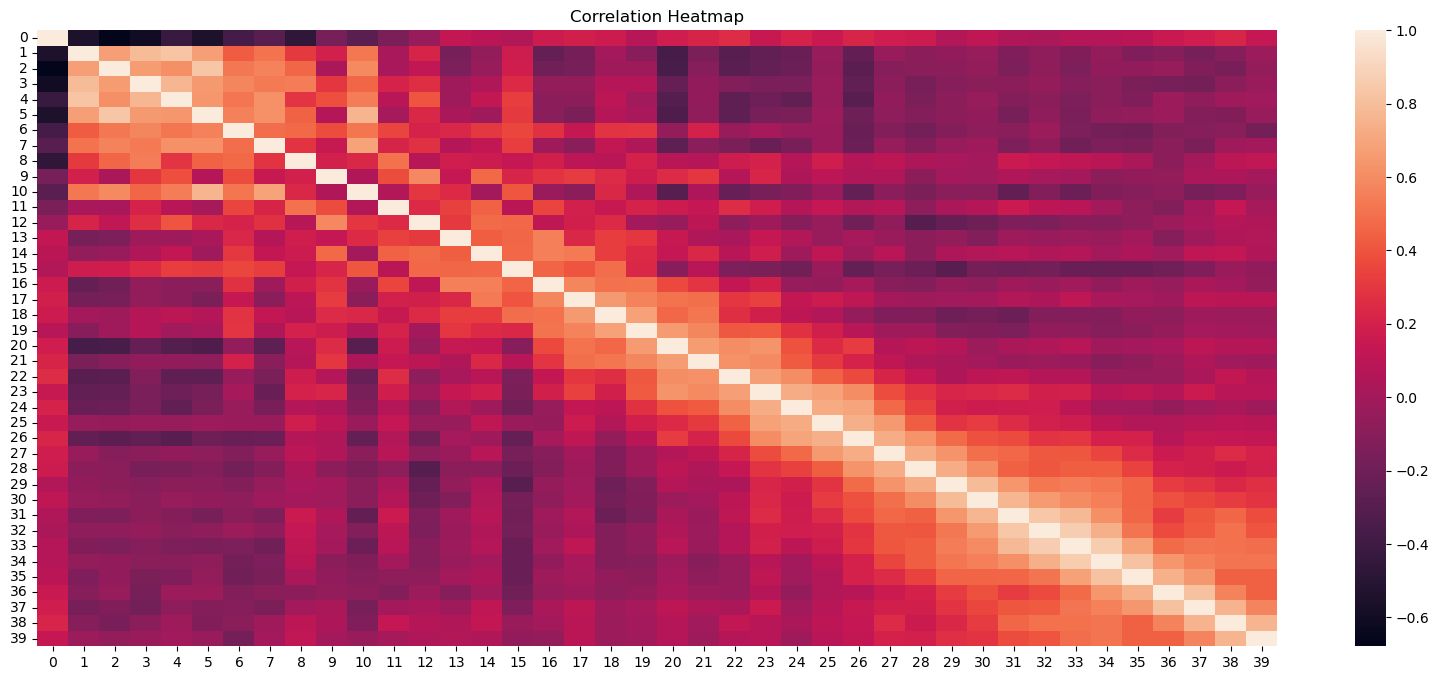

In [38]:
plt.figure(figsize=(20,8))
sns.heatmap(X.corr())
plt.title("Correlation Heatmap")
plt.show()

In [39]:
def LogisticRegressionPipeline(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    pipeline = Pipeline([('scaler',StandardScaler()),('LogisticRegression',LogisticRegression())])
    pipeline.fit(X_train,y_train)
    y_train_pred = pipeline.predict(X_train)
    y_pred = pipeline.predict(X_test)

    cmatrix = confusion_matrix(y_test,y_pred)

    print("Training Performance")
    print(classification_report(y_train,y_train_pred))
    print("-----------------------------------------")
    print("Test Performance")
    print(classification_report(y_test,y_pred))
    print("-----------------------------------------")

    cv_score = cross_val_score(pipeline,X,y,cv=5)
    average = lambda x: sum(x)/len(x)
    print("5-Folds Scores: ", cv_score)
    print("-----------------------------------------")
    print("5-Folds Average Score: ",average(cv_score))

    return cv_score, cmatrix

In [40]:
scores, cmatrix = LogisticRegressionPipeline(X,y)

Training Performance
              precision    recall  f1-score   support

       happy       0.81      0.85      0.83       154
         sad       0.84      0.80      0.82       153

    accuracy                           0.83       307
   macro avg       0.83      0.83      0.83       307
weighted avg       0.83      0.83      0.83       307

-----------------------------------------
Test Performance
              precision    recall  f1-score   support

       happy       0.89      0.82      0.85        38
         sad       0.83      0.90      0.86        39

    accuracy                           0.86        77
   macro avg       0.86      0.86      0.86        77
weighted avg       0.86      0.86      0.86        77

-----------------------------------------
5-Folds Scores:  [0.63636364 0.74025974 0.80519481 0.71428571 0.73684211]
-----------------------------------------
5-Folds Average Score:  0.7265892002734108


<Axes: >

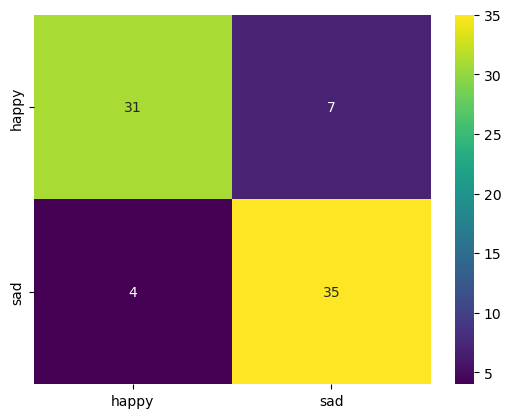

In [41]:
sns.heatmap(cmatrix,annot=True,fmt='.3g',cmap='viridis',xticklabels=['happy','sad'],yticklabels=['happy','sad'])

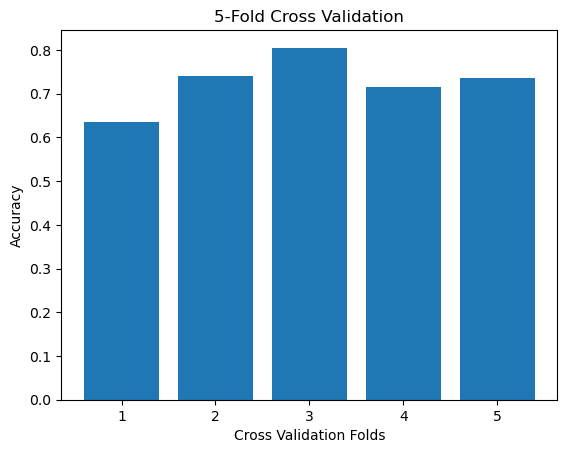

In [42]:
plt.bar(x=list(range(1,6)),height=scores)
plt.xlabel("Cross Validation Folds")
plt.ylabel("Accuracy")
plt.title("5-Fold Cross Validation")
plt.show()

## Mel Spectrogram features

In [43]:
dataf = feature_extraction(data,mfcc=False)
dataf

100%|██████████| 384/384 [00:23<00:00, 16.58it/s]


0         1         2         3         4         5         6  \
0    0.000006  0.000004  0.000007  0.000004  0.000004  0.000113  0.010258   
1    0.000010  0.000062  0.000121  0.000124  0.000140  0.002472  0.019176   
2    0.000015  0.000039  0.000191  0.000211  0.000450  0.001405  0.015065   
3    0.000001  0.000003  0.000018  0.000027  0.000068  0.000192  0.000435   
4    0.000100  0.000096  0.000092  0.000068  0.000046  0.000340  0.015522   
..        ...       ...       ...       ...       ...       ...       ...   
379  0.584026  0.000854  0.000105  0.000018  0.000614  0.020638  0.083738   
380  0.000039  0.000011  0.000006  0.000412  0.007097  0.017220  0.015673   
381  0.000367  0.000086  0.002112  0.002465  0.024503  0.084526  0.065258   
382  0.000077  0.000044  0.000832  0.001446  0.004995  0.040183  0.114143   
383  0.000030  0.000009  0.000027  0.000067  0.002824  0.014332  0.026667   

            7         8         9  ...       119       120       121  \
0    0.098926  0.067482  0.040675  ...  0.000055  0.000103  0.000051   
1    0.073547  0.093583  0.154635  ...  0.000048  0.000044  0.000041   
2    0.073743  0.153516  0.073446  ...  0.000049  0.000072  0.000047   
3    0.001680  0.007180  0.101973  ...  0.000110  0.000083  0.000171   
4    0.228489  0.263260  0.121607  ...  0.000364  0.000303  0.000180   
..        ...       ...       ...  ...       ...       ...       ...   
379  0.061419  0.052701  0.012844  ...  0.000343  0.000377  0.000544   
380  0.000889  0.000942  0.005822  ...  0.000002  0.000002  0.000004   
381  0.003117  0.001634  0.011607  ...  0.000003  0.000007  0.000013   
382  0.042317  0.021463  0.004327  ...  0.000027  0.000035  0.000060   
383  0.021352  0.018112  0.012602  ...  0.000022  0.000024  0.000016   

          122       123       124       125       126           127  class  
0    0.000088  0.000064  0.000044  0.000053  0.000019  2.238933e-06    sad  
1    0.000036  0.000023  0.000033  0.000040  0.000018  1.752120e-06  happy  
2    0.000052  0.000028  0.000036  0.000026  0.000017  1.221383e-06  happy  
3    0.000141  0.000186  0.000126  0.000076  0.000019  1.275138e-06    sad  
4    0.000221  0.000292  0.000357  0.000425  0.000312  2.626350e-05  happy  
..        ...       ...       ...       ...       ...           ...    ...  
379  0.000410  0.000387  0.000460  0.000445  0.000204  1.320768e-05    sad  
380  0.000006  0.000008  0.000011  0.000009  0.000003  2.532964e-07    sad  
381  0.000012  0.000010  0.000008  0.000007  0.000003  2.795023e-07  happy  
382  0.000048  0.000044  0.000037  0.000030  0.000019  1.315864e-06  happy  
383  0.000011  0.000018  0.000013  0.000017  0.000009  1.328438e-06    sad  

[384 rows x 129 columns]

In [44]:
X = dataf.iloc[:,:-1]
y = dataf.iloc[:,-1]

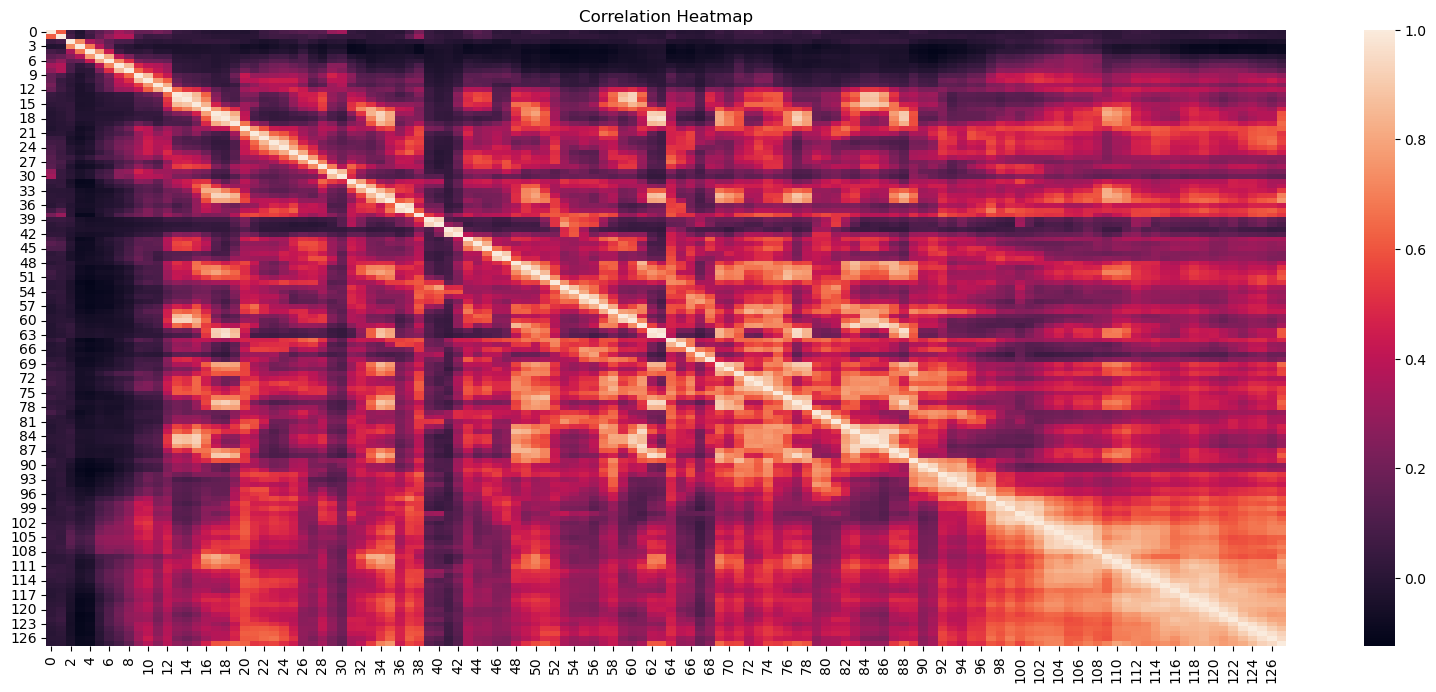

In [45]:
plt.figure(figsize=(20,8))
sns.heatmap(X.corr())
plt.title("Correlation Heatmap")
plt.show()

## Feature Scale

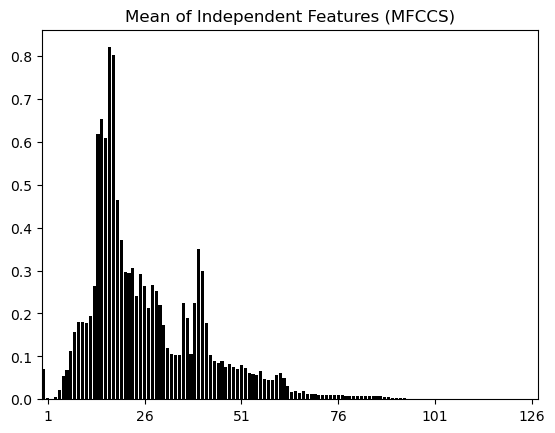

In [46]:
sns.barplot(x=X.columns,y=X.mean(axis=0),color='black')
plt.title("Mean of Independent Features (MFCCS)")
plt.xticks(ticks=list(range(1,129,25)))
plt.show()

In [47]:
scores, cmatrix = LogisticRegressionPipeline(X,y)

Training Performance
              precision    recall  f1-score   support

       happy       0.90      0.68      0.77       154
         sad       0.74      0.92      0.82       153

    accuracy                           0.80       307
   macro avg       0.82      0.80      0.80       307
weighted avg       0.82      0.80      0.80       307

-----------------------------------------
Test Performance
              precision    recall  f1-score   support

       happy       0.70      0.61      0.65        38
         sad       0.66      0.74      0.70        39

    accuracy                           0.68        77
   macro avg       0.68      0.67      0.67        77
weighted avg       0.68      0.68      0.67        77

-----------------------------------------
5-Folds Scores:  [0.67532468 0.74025974 0.67532468 0.72727273 0.69736842]
-----------------------------------------
5-Folds Average Score:  0.7031100478468899


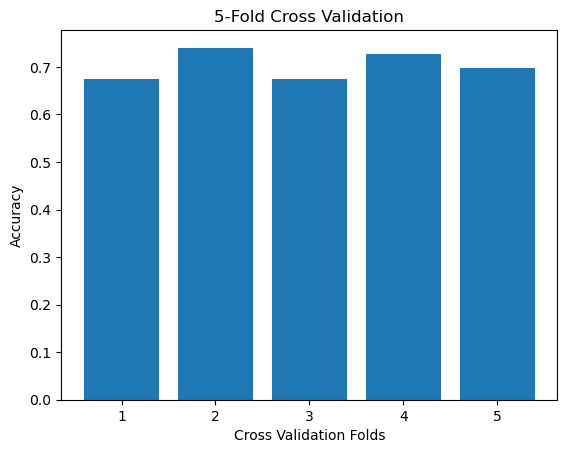

In [48]:
plt.bar(x=list(range(1,6)),height=scores)
plt.xlabel("Cross Validation Folds")
plt.ylabel("Accuracy")
plt.title("5-Fold Cross Validation")
plt.show()